In [1]:
import os
import numpy as np
import pickle
import shutil 
import pImpactR as impact
import matplotlib.pyplot as plt
import time

# Simulation Setting

In [2]:
npt = 128
Espread = 1.0e-2
pipe_radius = 0.06
nturn = 1024

# Lattice

In [3]:
beam,lattice=impact.readInputFile('IOTA.Chris.in')
beam.nCore_y = 1
beam.nCore_z = 1

reading ImpactZ input file (IOTA.Chris.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice = [ item for item in lattice if not item.type == '-8' ]
lattice[0].turns = 1
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = int(np.ceil(lattice[i].length*80))
    if 'pipe_radius' in lattice[i].keys() and lattice[i].type!='dipole':
        lattice[i].pipe_radius = pipe_radius

elemWrite = impact.getElem('write_raw_ptcl')
elemWrite.file_id   = 999
elemWrite.format_id = 2
lattice.append(elemWrite)

In [5]:
NL_nu = lattice[1].tune_advance
NL_L  = lattice[1].length
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

In [6]:
arc = lattice.copy()
arc.pop(1)


             length: 1.8 [m]
           n_sckick: 144 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 0.06 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [7]:
ke = beam.kinetic_energy
freq = beam.frequency
mass = beam.mass
gam0 = 1.0+beam.kinetic_energy/mass
bet0 = np.sqrt(1.0-1.0/gam0**2)
bg0  = np.sqrt(gam0**2-1.0)
q_m  = beam.multi_charge.q_m[0]

In [8]:
def Impact2norm(data_in,bg0,bet0,sign=1):
    data=data_in.copy()
    data[:,5] = -(np.sqrt(1.0-2.0*data[:,5]/mass/(bet0*bg0)+(data[:,5]/mass)**2/bg0**2)-1.0)
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2Impact(data_in,bg0,bet0,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
    data[:,5] = (bg0*np.sqrt(1/bet0**2+2.0*data[:,5]+data[:,5]**2)-bg0/bet0)*mass
    return data

In [9]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

In [10]:
SextIndex=[]
SextStrength=[]
for i in range(len(arc)):
    if arc[i]['type']=='multipole_thin':
        SextIndex.append(i)
        SextStrength.append(arc[i]['KL_sext'])

In [11]:
with open('result.12sext.12oct','rb') as f:
    result = pickle.load(f)

In [12]:
result.population.shape

(128, 24)

In [13]:
result.population_energies.shape

(128,)

In [14]:
result.population_energies[0]

0.00036411218524199355

In [15]:
bounds = [(-2.0,2.0)]*2*len(SextIndex)
result.population = (result.population - 0.5)*4.0
print(result.population[0,:])

[-0.13602446  0.06411187  0.37503425  0.5276296  -0.45159165 -0.96310911
  0.29587225 -1.55235895  0.1022019  -0.15700245 -0.07190923 -1.45435006
 -0.03505036 -1.66291198 -0.05217757  0.25299879  0.08336465 -0.52920187
 -0.40863121 -1.14555735  0.1248202   1.74901596 -0.5942519  -0.85294483]


In [16]:
# objFunc(result.population[0,:])

# Compare Invariants

In [17]:
elemTBT = impact.getElem('TBT_integral')
elemTBT.strength_t = NL_t
elemTBT.transverse_scale_c = NL_c
elemTBT.betx = betx
elemTBT.alfx = alfx
elemTBT.file_id = 10
elemTBT.pID_begin = 1
elemTBT.pID_end = npt

elemTBT_old = impact.getElem('TBT_integral_onMomentum')
elemTBT_old.strength_t = NL_t
elemTBT_old.transverse_scale_c = NL_c
elemTBT_old.betx = betx
elemTBT_old.alfx = alfx
elemTBT_old.file_id = 11
elemTBT_old.pID_begin = 1
elemTBT_old.pID_end = npt

popout = lattice.pop(-1)
lattice.append(elemTBT)
lattice.append(elemTBT_old)

lattice[0].turns = nturn

In [18]:
x=get_truncated_normal(sd=0.2,low=-0.6,upp=0.6,n=npt*5)
pData0=np.zeros([npt,9])
pData0[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData0[:,5] = pData0[:,5]/0.2*Espread
pData0[:,6] = q_m
pData0[:,-1] = np.arange(1,npt+1)

def trackOneTurn(arg):
    for i,j in enumerate(SextIndex):
        lattice[j+1]['KL_sext']=arg[2*i]
        lattice[j+1]['KL_oct'] =arg[2*i+1]

    pData2 = norm2Impact(pData0,bg0,bet0,-1)
    impact.writeParticleData(pData2,ke,mass,freq)
    impact.writeInputFile(beam,lattice)
    impact.run(beam)
    dum,TBToff = impact.readTBT_integral(10)
    dum,TBTon = impact.readTBT_integral_onMomentum(11)
    print('npt=',len(dum))
    return dum,TBTon,TBToff

In [19]:
testarg = [0]*2*len(SextStrength)
for i,kl in enumerate(SextStrength):
    testarg[2*i]=SextStrength[i]
index,TBTon,TBToff = trackOneTurn(testarg)
print(index)

npt= 120
[  1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56
  57  58  59  60  61  62  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 102 103 104 105 106 107 109 111 112 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128]


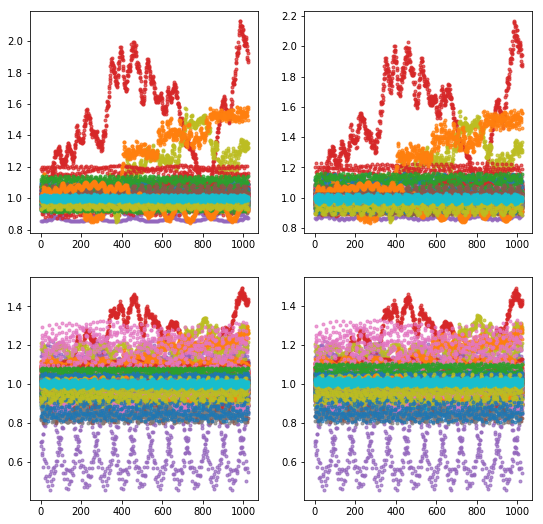

In [20]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
for i in range(len(index)):
    plt.plot(TBTon[:,0,i]/TBTon[0,0,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,2)
for i in range(len(index)):
    plt.plot(TBToff[:,0,i]/TBToff[0,0,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,3)
for i in range(len(index)):
    plt.plot(TBTon[:,1,i]/TBTon[0,1,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,4)
for i in range(len(index)):
    plt.plot(TBToff[:,1,i]/TBToff[0,1,i],marker='.',ls='',alpha=0.7)

In [21]:
index,TBTon,TBToff = trackOneTurn(result.population[0,:])
print(index)

npt= 121
[  1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56
  57  58  59  60  61  62  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 109 111 112 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128]


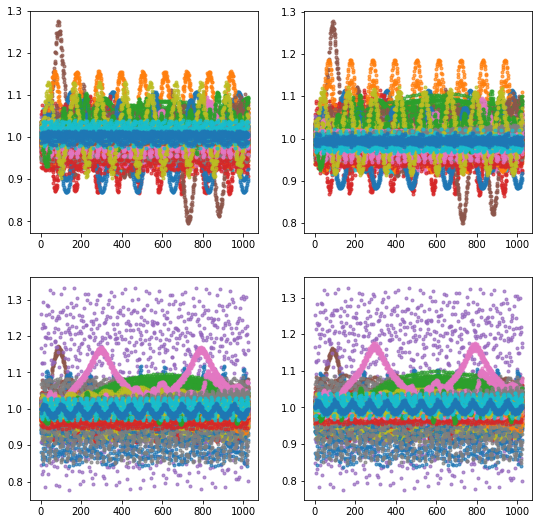

In [22]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
for i in range(len(index)):
    plt.plot(TBTon[:,0,i]/TBTon[0,0,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,2)
for i in range(len(index)):
    plt.plot(TBToff[:,0,i]/TBToff[0,0,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,3)
for i in range(len(index)):
    plt.plot(TBTon[:,1,i]/TBTon[0,1,i],marker='.',ls='',alpha=0.7)
plt.subplot(2,2,4)
for i in range(len(index)):
    plt.plot(TBToff[:,1,i]/TBToff[0,1,i],marker='.',ls='',alpha=0.7)